In [23]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
from Extract_features import *
from skimage.feature import hog
from sklearn.svm import SVC,LinearSVC
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
from scipy.ndimage.measurements import label

import pickle

import imageio
#imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip, ImageClip
from IPython.display import HTML
%matplotlib inline

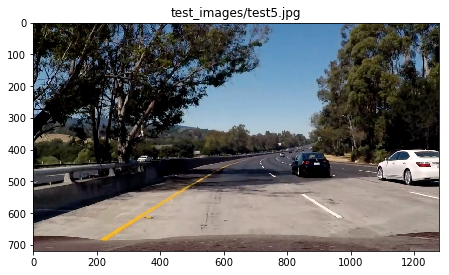

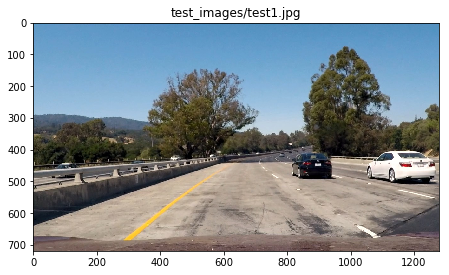

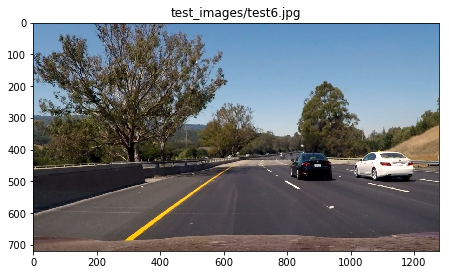

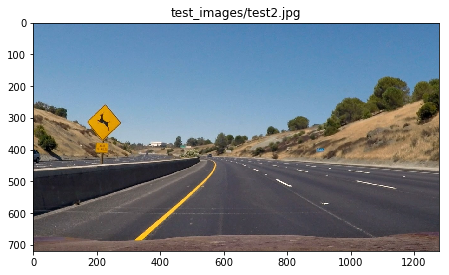

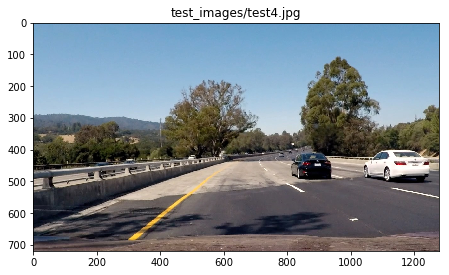

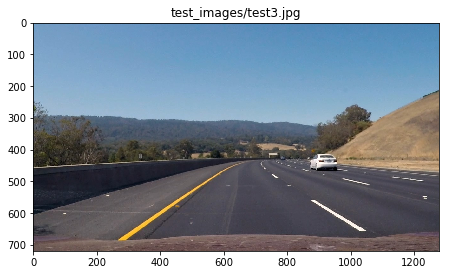

In [2]:
test_images=glob.glob('test_images/*.jpg')
#print(images)
read_images=[]
count=0
    

for img in test_images:
    
    read_images.append(img)
    read_img=mpimg.imread(img)
    plt.figure(figsize=(16,16))
    plt.subplot(3,2,count+1)
    plt.imshow(read_img)

    plt.title(img)
plt.show()

Store the DataSet in car and not_car in form of list to extract features

In [3]:


car = glob.glob("vehicles/*/*.png")
not_car = glob.glob("non-vehicles/*/*.png")

#print(cars)
#print(notcars)



In [4]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(car, not_car)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(car))
notcar_ind = np.random.randint(0, len(not_car))
    
# Read in car / not-car images
car_image = mpimg.imread(car[car_ind])
notcar_image = mpimg.imread(not_car[notcar_ind])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


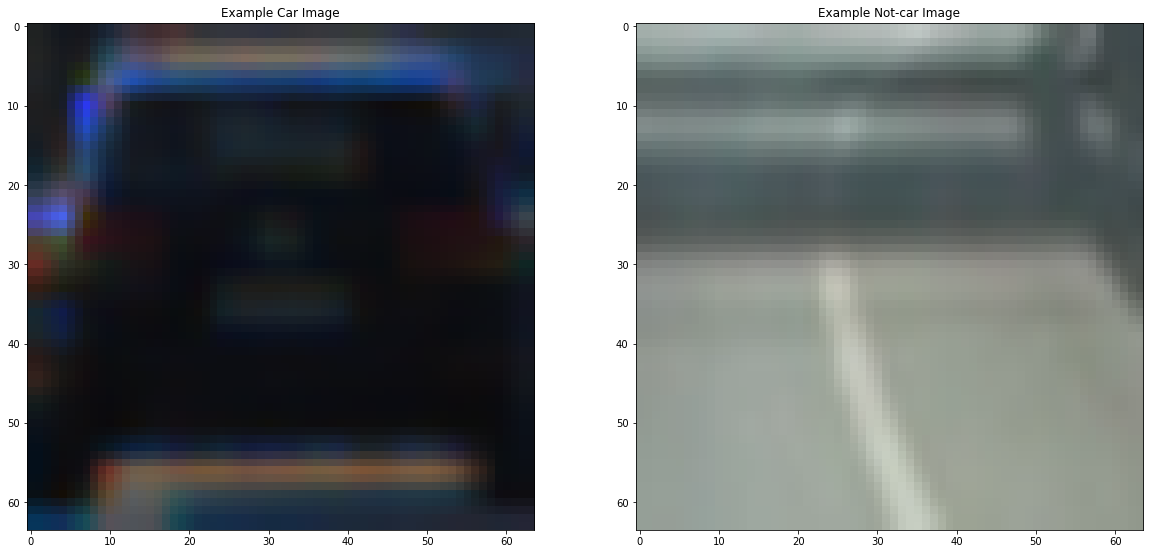

In [5]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Example Car Image')
ax1.imshow(car_image)

ax2.set_title('Example Not-car Image')
ax2.imshow(notcar_image)


In [6]:
sample_size=500

sample_car=car[0:sample_size]
sample_not_car=not_car[0:sample_size]
print(len(sample_not_car))

500


In [7]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [10]:
hog_images=[]
sample_img=[]
def extract_features(imgs, color_space='BGR', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image= cv2.imread(file)
        image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        sample_img.append(image)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = spatial_bin(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features,hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
                hog_images.append(hog_image)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


In [11]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) 
hist_bins = 32   
spatial_feat = True 
hist_feat = True 
hog_feat = True 

#print(color_space,'',orient,'',pix_per_cell,'',cell_per_block,'',hog_channel,'',spatial_size,'',hist_bins,'',spatial_feat,'',hist_feat,'',hog_feat)

car_features = extract_features(car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(not_car, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)



In [ ]:
for i in range(16):
    # Plot the examples
    car_int = np.random.randint(0, len(sample_car))
    if(hog_images is not None):
        fig = plt.figure()
        plt.subplot(121)
        plt.imshow(sample_img[car_int], cmap='gray')
        plt.title('Example Car Image')
        plt.subplot(122)
        plt.imshow(hog_images[car_int], cmap='gray')
        plt.title('HOG Visualization')
        plt.show()
    

In [12]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

In [13]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
print(len(X))
print(len(y))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

17760
17760


In [14]:
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6156


In [ ]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


In [22]:
svc = SVC(kernel='rbf')

svc.fit(X_train,y_train )

t=time.time()
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


0.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9918


In [24]:
svc_pickle = {}
svc_pickle["svc"] = svc
svc_pickle["scaler"] = X_scaler
svc_pickle["orient"] = orient
svc_pickle["pix_per_cell"] = pix_per_cell
svc_pickle["cell_per_block"] = cell_per_block
svc_pickle["spatial_size"] = spatial_size
svc_pickle["hist_bins"] = hist_bins
svc_pickle["colorspace"] = color_space
svc_pickle["hog_channel"] = hog_channel
pickle.dump( svc_pickle, open( "./svc_pickle.p", "wb" ) )

In [25]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


In [34]:
def single_img_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):

    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(imgs, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = spatial_bin(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
        
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        #rint('h',len(hog_features))
    #9) Return concatenated array of features
    return np.concatenate(img_features)




In [35]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [36]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

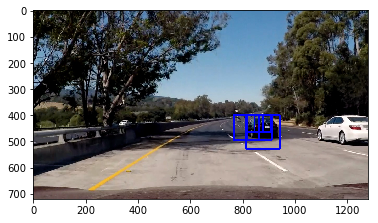

In [41]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) 
hist_bins = 32   
spatial_feat = True 
hist_feat = True 
hog_feat = True 
y_start_stop = [400,720 ]
image = mpimg.imread(test_images[0])
draw_image = np.copy(image)

windows1=slide_window(image, x_start_stop=[750, 1280], y_start_stop=y_start_stop, 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
windows2=slide_window(image, x_start_stop=[750, 1280], y_start_stop=y_start_stop, 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
windows3=slide_window(image, x_start_stop=[750, 1280], y_start_stop=y_start_stop, 
                     xy_window=(64, 64), xy_overlap=(0.5, 0.5))

windows=windows1+windows2+windows3

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   

plt.imshow(window_img)

In [42]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [43]:
heat = np.zeros_like(image[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,hot_windows)

# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

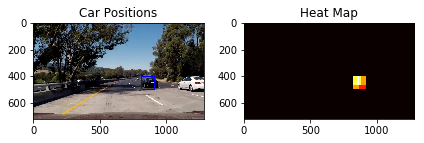

In [44]:

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()



In [49]:
def car_image(image):
    
    color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) 
    hist_bins = 32   
    spatial_feat = True 
    hist_feat = True 
    hog_feat = True 
    y_start_stop = [400,720 ]
    image = mpimg.imread(test_images[0])
    draw_image = np.copy(image)

    windows1=slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(96, 96), xy_overlap=(0.5, 0.5))
    windows2=slide_window(image, x_start_stop=[750, 1150], y_start_stop=y_start_stop, 
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    windows3=slide_window(image, x_start_stop=[750, 1150], y_start_stop=y_start_stop, 
                         xy_window=(64, 64), xy_overlap=(0.5, 0.5))

    windows=windows1+windows2+windows3

    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)   

#     plt.imshow(window_img)
    return hot_windows

In [50]:
def heat_threshold(img,windows_img):
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,windows_img)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img,heatmap

In [51]:
def pipeline(img):
    
    threshold = 1
    windows_imgs = car_image(img)

    draw_img, heat_map = heat_threshold(img,windows_imgs)
    
    
#     fig = plt.figure()
#     plt.subplot(121)
#     plt.imshow(draw_img)
#     plt.title('Car Positions')
#     plt.subplot(122)
#     plt.imshow(heatmap, cmap='hot')
#     plt.title('Heat Map')
#     fig.tight_layout()

    
    return draw_img

In [ ]:


white_output = 'Pvideo_test02.mp4'
clip1 = VideoFileClip("./project_video.mp4")

white_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()

[MoviePy] >>>> Building video Pvideo_test02.mp4
[MoviePy] Writing video Pvideo_test02.mp4


  4%|▎         | 46/1261 [04:51<2:07:47,  6.31s/it]

In [ ]:
for i in range(2):
    channel1_hist,channel2_hist,channel3_hist,bin_centers,hist_features=color_hist1(cv2.imread(sample_car[i+250]),nbins=32,bins_range=(0,256))
    # Plot a figure with all three bar charts
    if channel1_hist is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, channel1_hist[0])
        plt.xlim(0, 256)
        plt.title('R Histogram'+str(i))
        plt.subplot(132)
        plt.bar(bin_centers, channel2_hist[0])
        plt.xlim(0, 256)
        plt.title('G Histogram'+str(i))
        plt.subplot(133)
        plt.bar(bin_centers, channel3_hist[0])
        plt.xlim(0, 256)
        plt.title('B Histogram'+str(i))
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')


In [ ]:
for i in range(2):
    # Read a color image
    img = cv2.imread(sample_car[i+200])

    # Select a small fraction of pixels to plot by subsampling it
    scale = max(img.shape[0], img.shape[1], 64) / 64  # at most 64 rows and columns
    img_small = cv2.resize(img, (np.int(img.shape[1] / scale), np.int(img.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

    # Convert subsampled image to desired color space(s)
    img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
    img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
    img_small_LUV = cv2.cvtColor(img_small, cv2.COLOR_BGR2LUV)
    img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

    # Plot and show
    plot3d(img_small_RGB, img_small_rgb)
    plt.show()

    plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
    plt.show()
    
    plot3d(img_small_LUV, img_small_rgb, axis_labels=list("LUV"))
    plt.show()